# Tuning curves and place cells

In this lesson, we'll learn:

- How to visualise the response of a single neuron with a **peri-stimulus time histogram (PSTH)** and **tuning curves**
- How to use these techniques to study space-selective cells (place cells) in the hippocampus
- How to quantify the selectivity of single cells

In [1]:
import numpy as np
import scipy
import scipy.stats
import scipy.io
import matplotlib.pyplot as plt
#from ipywidgets import interact
#import ipywidgets as widgets
from tqdm import tqdm
import seaborn as sns
import pickle
import sys
import os
sys.path.append(os.path.abspath("code"))
from utils import download_data

In [2]:
# Download data
download_data('https://surfdrive.surf.nl/files/index.php/s/FeDX3LfbJ4pC7T6')

### <font color='teal'> Introduction: Visualising the response of a neuron </font>

In order to understand how neurons encode information about the external world, neuroscientists have been in the habit of looking for changes in the activity of individual cells as a function of some 'parameter' (e.g.: presence/absence of a stimulus, time elapsed from a certain event, value of a particular feature, ...)

A first important step in the characterization of this selectivity is the **visual inspection of neural responses**. 

In this lesson, we will look at three useful methods to visualise the activity of single neurons and apply them to a couple of paradigmatic neural data analysis cases: 

1. The response of neurons in the auditory cortex during a sound presentation
2. The analysis of hippocampal place cells

#### **Raster plots**

Raster plots are useful for visualising the spiking activity of neurons in a given time window. They show each spike as a for or a small line, with a position along the $x$ axis that corresponds to the emission time. The $y$ axis usually display different neurons or different trials. In order to build a raster plot, we

- Isolate the spikes emitted during the periods of interest
- Align the spikes to the onset of the period on interest
- Plot each spike as a dot aligned with the corresponding emission time

#### **Peri-stimulus time histogram (PSTH)**

PSTHs are used to visualise the time course of the activation of a neuron in response to a certain event that is repeated a set number of times. To build the PSTH, we

- Build the raster plot of a (single) neuron
- Bin the interval into $N$ of length $\Delta$
- Count the total number of spikes $n_i$ that fall into bin $i$
- Plot the count $n_i$ for each bin or the firing rate $r_i = n_i/\Delta$

This yields an histogram of the number of spikes (or firing rate) for each time bin in the period of interest.

#### **Tuning curves**

To investigate the modulation of the activity of a single neurons as a functions of a continous parameter $S$ (usually an external stimulus), we can look at a neuron's fitting curve. 

The tuning curve $\langle r\rangle = f(s)$ gives the expected firing rate of the neuron given that $S$ assumes the value of $s$. To build tuning cirve, we

- Bin the parameter $S$ in $N$ bins of size $s\Delta$
- Compute for each bin, the average firing rate of the neuron during periods when $S$ assumes values within the bin
- Optionally, fit a functional form to the obtained histogram

This procedure yields an histogram that gives us information about hoe the neurons responds to different values of $S$.

### <font color='teal'> Raster plot and PSTH: Sound presentation </font>
____

To see how to build a PSTH, we'll look at some simulated data. 

The data contains the recordings from 20 neurons in the auditory cortex, collected during the repeated presentation of two different sounds. Each sound is presented 50 times, each with a duration of 2 seconds and a pause of 3. 

The `phts_data.pickle` contains the data in a python dictionary, with the following keys:
- `spike_times` containing a list of lists with the time stamps of the emitted spikes of each neuron in seconds
- `stim_onsets` containing a list of the onset times of each of the presented sounds in seconds
- `stim_type` contains a list of the sound identity corresponding to the onsets in `stim_onsets`
- `stim_duration` contains a single number, giving the duration of the sounds in seconds

In [3]:
# Importing the data
with open('data/psth_data.pickle', 'rb') as handle:
    data = pickle.load(handle)

spike_times   = data['spike_times']
stim_onsets   = data['stim_onsets']
stim_type     = data['stim_type']
stim_duration = data['stim_duration']

Now, we extract the periods around the stimulus presentation (0.5 seconds before and after the onset/offset) and align the spike times to the stimulus onset, separately for each of the two stimuli.

In [11]:
# Cut and align to stimulus presentation
psth_onset = - 0.5
psth_offset = stim_duration + 0.5

# STIMULUS 1
aligned_spikes_stim1 = []
stim1_onsets = stim_onsets[stim_type == 1]

for cell_spikes in spike_times:
    aligned_spikes = []

    for stim_onset in stim1_onsets:
        onset = stim_onset + psth_onset
        offset = stim_onset + psth_offset

        # Take only spikes during the stimulus, aligned to stimulus onset
        stim_spikes = [spike - stim_onset for spike in cell_spikes if (spike >= onset and spike < offset)]
        aligned_spikes.append(stim_spikes)
    
    aligned_spikes_stim1.append(aligned_spikes)

# STIMULUS 2
aligned_spikes_stim2 = []
stim2_onsets = stim_onsets[stim_type == 2]

for cell_spikes in spike_times:
    aligned_spikes = []

    for stim_onset in stim2_onsets:
        onset = stim_onset + psth_onset
        offset = stim_onset + psth_offset

        # Take only spikes during the stimulus, aligned to stimulus onset
        stim_spikes = [spike - stim_onset for spike in cell_spikes if (spike >= onset and spike < offset)]
        aligned_spikes.append(stim_spikes)
    
    aligned_spikes_stim2.append(aligned_spikes)

Let's plot the response of each neuron to the sound using a raster plot and plot as well the PSTH.

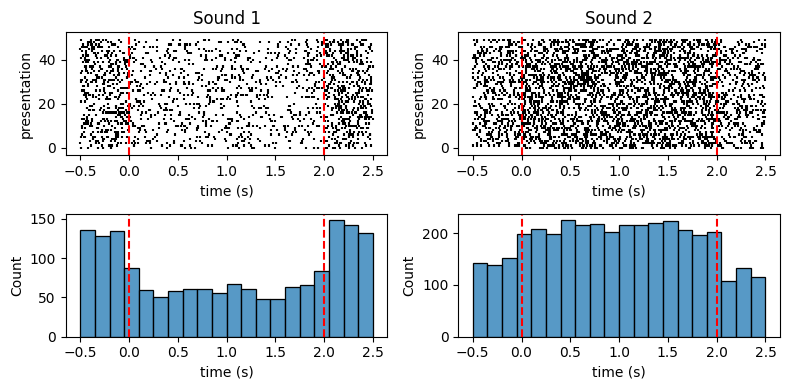

In [13]:
neuron = 6
psth_spikes_stim1 = [item for sublist in aligned_spikes_stim1[neuron] for item in sublist]
psth_spikes_stim2 = [item for sublist in aligned_spikes_stim2[neuron] for item in sublist]

plt.figure(figsize=(8,4))

plt.subplot(2,2,1)
plt.title('Sound 1')
plt.eventplot(aligned_spikes_stim1[neuron],color='k');
plt.axvline(x=0,linestyle='--',c='r')
plt.axvline(x=2,linestyle='--',c='r')
plt.xlabel('time (s)')
plt.ylabel('presentation')

plt.subplot(2,2,2)
plt.title('Sound 2')
plt.eventplot(aligned_spikes_stim2[neuron],color='k');
plt.axvline(x=0,linestyle='--',c='r')
plt.axvline(x=2,linestyle='--',c='r')
plt.xlabel('time (s)')
plt.ylabel('presentation')

plt.subplot(2,2,3)
sns.histplot(psth_spikes_stim1,bins=20)
plt.axvline(x=0,linestyle='--',c='r')
plt.axvline(x=2,linestyle='--',c='r')
plt.xlabel('time (s)')


plt.subplot(2,2,4)
sns.histplot(psth_spikes_stim2,bins=20)
plt.axvline(x=0,linestyle='--',c='r')
plt.axvline(x=2,linestyle='--',c='r')
plt.xlabel('time (s)')


plt.tight_layout()

As you can see, some neurons vlearly show a modulation of the firing rate depending on which stimulus is being presented and in this case the modulation is sustained throughout the whole stimulus presentation.

### <font color='teal'> Tuning curve: place cells </font>
____

Place cells are cells in the hippocampus that activate when the animal passes through a specific place in an environment. Together, place cells form a spatial map of the environment that is supposed to support episodic memory.

In a typical place cell experiment, multiple hippocampal neurons are recorded at the same time. For each cell, we get the time series of the spike times that each cell emitted. Additionally, we get information about the position of the animal at any point in time. Typically, the position is obtained by filming the animal movement and using a video tracking software. To find the animal position at the moment of the emission of each spike (which is the basic unit of information for our analysis), we will have to synchronise and realign these different time series

#### Simulating place cell activity

To get started, we'll create and analyse simulated data. First, we'll generate *ground truth* firing rates and then simulate spike trains as inhomogeneous Poisson processes with a rate determined by the current animal position.

An inhomogeneous Poisson process describes the instantaneous probability to have an event between $t$ and $t+dt$:

$$p(s, [t, t+dt]) = \lambda(t) dt$$

In [14]:
# Parameters
track_length = 200      # The length of the linear track 
avg_firing_rate = 5     # The peak firing rate averaged across the population 
n_cells = 100           # The number of cells being recorded

pf_centers = np.random.rand(n_cells) * track_length                        # The centers of the place fields
pf_size = np.random.gamma(10, size = n_cells)                              # The width of the place fields
pf_rate = np.random.exponential(scale = avg_firing_rate, size = n_cells)   # The peak firing rates

Text(0, 0.5, '# Cell')

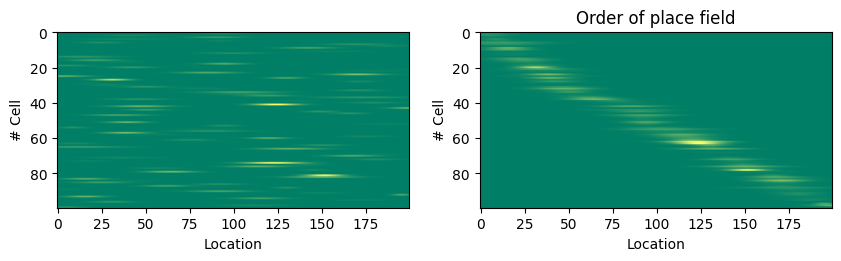

In [24]:
bins = np.arange(0, 200)
true_firing_rate_maps = np.zeros((n_cells, len(bins)))
for i in range(n_cells):
    true_firing_rate_maps[i,:] = pf_rate[i] * np.exp(- (bins - pf_centers[i])**2 / (2 * pf_size[i]**2))

plt.figure(figsize=(10,4))

plt.subplot(1,2,1)
plt.imshow(true_firing_rate_maps, cmap='summer')
plt.xlabel('Location')
plt.ylabel('# Cell')

ix = np.argsort(pf_centers)
plt.subplot(1,2,2)
plt.imshow(true_firing_rate_maps[ix,:], cmap='summer')
plt.title('Order of place field')
plt.xlabel('Location')
plt.ylabel('# Cell')


Now, let's simulate the animal's trajectory. It will shuttle back and forth on the linear track and it will stop at the two ends to eat. We will make a very rough simulation in which the running speed is constant.

`t` and `x` corresponds to the time and position readouts for all the video frames, respectively.

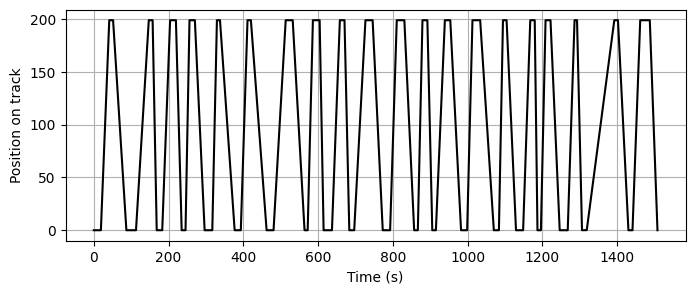

In [28]:
n_runs = 20
avg_running_speed = 10
fps = 30   # The number of video frames per second

running_speed_a = np.random.chisquare(10, size=n_runs) # Running speed in the two directions
running_speed_b = np.random.chisquare(10, size=n_runs) 

stopping_time_a = np.random.chisquare(15, size=n_runs) # The time the animal will spend at the two ends of the track
stopping_time_b = np.random.chisquare(15, size=n_runs)

x = np.array([])
for i in range(n_runs):
    stop1 = np.ones((int(stopping_time_a[i]*fps),)) * 0.
    run_length = len(bins) * fps / running_speed_a[i]
    run1 = np.linspace(0., float(len(bins)-1), int(run_length))
    stop2 = np.ones((int(stopping_time_b[i]*fps),)) * (len(bins)-1.)
    run_length = len(bins) * fps / running_speed_b[i]
    run2 = np.linspace(len(bins)-1., 0., int(run_length))
    x = np.concatenate((x, stop1, run1, stop2, run2))
t = np.arange(len(x))/fps

#Plot the trajectory
plt.figure(figsize = (8,3))
plt.plot(t, x, 'k')
plt.xlabel('Time (s)')
plt.ylabel('Position on track')
plt.grid()

The cell bellow draws spikes according to an inhomogeneous Poisson process. This is the heart of the simulation. Analyse the `for` loop closely!

In [ ]:
sampling_rate = 10000
t_sampling = np.arange(0, t[-1], 1 / sampling_rate)
x_sampling = np.floor(np.interp(t_sampling, t, x))
noise_firing_rate = 0.1
spikes = []

for i in tqdm(range(n_cells)):

    # Get the firing rates at each location and time instant + Noise
    inst_rates = true_firing_rate_maps[i, x_sampling.astype(np.int32)] + noise_firing_rate

    # Convert the rates into spikes
    spikes_loc = np.random.poisson(inst_rates / sampling_rate)

    # Indices where spikes lov is non-zeros, i.e., indices of when spikes occur
    sp = np.argwhere(spikes_loc)

    # Get spike times
    t_sp = t_sampling[sp]
    spikes.append(t_sp)